In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10
from art.attacks.evasion.projected_gradient_descent import ProjectedGradientDescent

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128) 

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

In [3]:
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/Adversarial PGD")
file = "PGD_stanford.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    activations_fc2, activations_fc1, activations_conv = [], [], []
    mask_fc2, mask_fc1, mask_conv = torch.zeros(1, 512), torch.zeros(1, 1024), torch.zeros(4096)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        self.activations_conv.append(x)
        x = F.relu(self.fc1(x))
        self.activations_fc1.append(x)
        x = F.relu(self.fc2(x))
        self.activations_fc2.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)*self.mask_conv
        x = F.relu(self.fc1(x))*self.mask_fc1
        x = F.relu(self.fc2(x))*self.mask_fc2
        x = self.fc3(x)
        return x
    
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

## MaskModel

In [5]:
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    mask_fc2, mask_fc1, mask_conv = torch.ones(1, 512), torch.ones(1, 1024), torch.ones(4096)
        
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)*self.mask_conv.to(device)
        x = F.relu(self.fc1(x))*self.mask_fc1.to(device)
        x = F.relu(self.fc2(x))*self.mask_fc2.to(device)
        x = self.fc3(x)
        return x
    
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
mask_model = MaskModel().to(device)

# Load pre-trained model
mask_model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(mask_model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mask_model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=mask_model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskModel(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout)

## Pruning

In [6]:
model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))

activations_fc2 = model.activations_fc2
activations_fc1 = model.activations_fc1
activations_conv = model.activations_conv

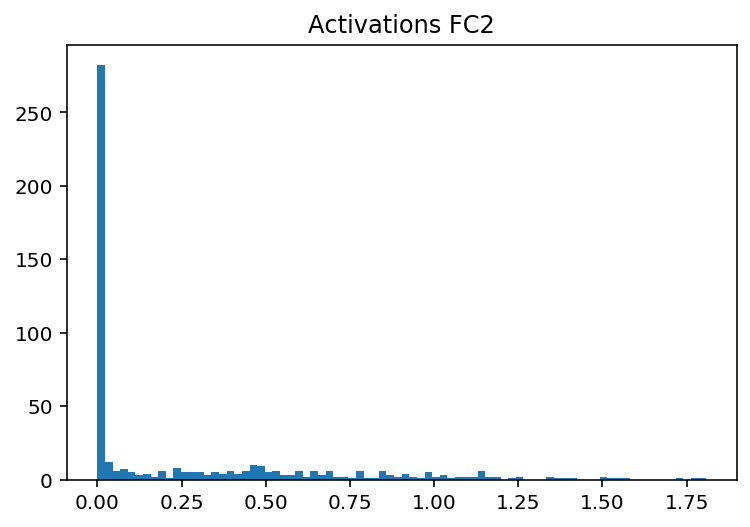

In [7]:
n = len(activations_fc2)
element0 = activations_fc2.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc2.pop()
    act[e+1,:,:] = elementX

mean_activations_fc2 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc2.numpy()
plt.hist(ma,80)
plt.title('Activations FC2')
plt.show()

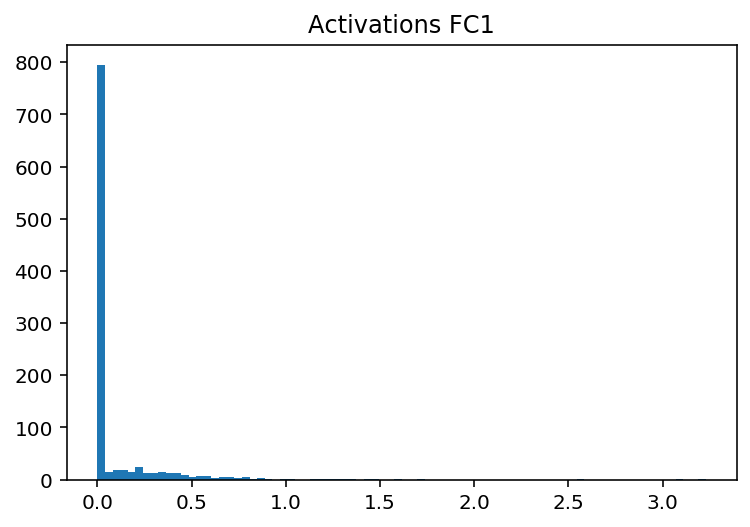

In [8]:
n = len(activations_fc1)
element0 = activations_fc1.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc1.pop()
    act[e+1,:,:] = elementX

mean_activations_fc1 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc1.numpy()
plt.hist(ma,80)
plt.title('Activations FC1')
plt.show()

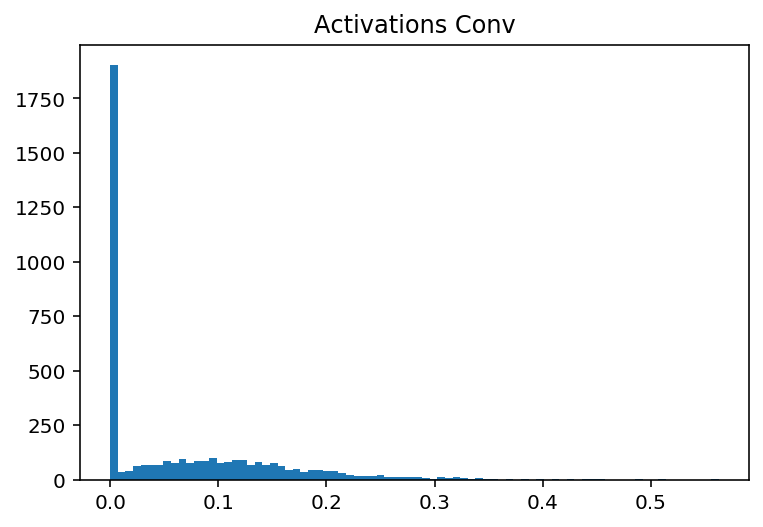

In [9]:
n = len(activations_conv)
element0 = activations_conv.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_conv.pop()
    act[e+1,:,:] = elementX

mean_activations_conv = torch.mean(act,dim=[0,1])
ma = mean_activations_conv.numpy()
plt.hist(ma,80)
plt.title('Activations Conv')
plt.show()

In [10]:
# save different masks for different percentages

masks_fc2 = dict()
masks_fc1 = dict()
masks_conv = dict()

for percentage in range(10):
# for percentage in [0, 4, 5, 6, 7, 8, 9]:
#     FC2
    s_ma_fc2, idx_ma_fc2 = torch.sort(mean_activations_fc2)
    m_fc2 = torch.ones(mean_activations_fc2.size()).to(device)
    nn_fc2 = mean_activations_fc2.size(0)
    ind_r_fc2 = round((percentage/10)*nn_fc2)
    m_fc2[idx_ma_fc2[:ind_r_fc2]] = 0.0
    n1_fc2 = m_fc2.sum()
    model.mask_fc2 = m_fc2
    masks_fc2[percentage/10] = model.mask_fc2
    
#     FC1
    s_ma_fc1, idx_ma_fc1 = torch.sort(mean_activations_fc1)
    m_fc1 = torch.ones(mean_activations_fc1.size()).to(device)
    nn_fc1 = mean_activations_fc1.size(0)
    ind_r_fc1 = round((percentage/10)*nn_fc1)
    m_fc1[idx_ma_fc1[:ind_r_fc1]] = 0.0
    n1_fc1 = m_fc1.sum()
    model.mask_fc1 = m_fc1
    masks_fc1[percentage/10] = model.mask_fc1


#     Conv
    s_ma_conv, idx_ma_conv = torch.sort(mean_activations_conv)
    m_conv = torch.ones(mean_activations_conv.size()).to(device)
    nn_conv = mean_activations_conv.size(0)
    ind_r_conv = round((percentage/10)*nn_conv)
    m_conv[idx_ma_conv[:ind_r_conv]] = 0.0
    n1_conv = m_conv.sum()
    model.mask_conv = m_conv
    masks_conv[percentage/10] = model.mask_conv

In [11]:
# evaluate with the new masks
acc = []
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    model.mask_fc2 = mask_fc2
    model.mask_fc1 = mask_fc1
    model.mask_conv = mask_conv
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 66.5 %
Pruned 0.1  Accuracy: 66.5 %
Pruned 0.2  Accuracy: 66.5 %
Pruned 0.3  Accuracy: 66.5 %
Pruned 0.4  Accuracy: 66.5 %
Pruned 0.5  Accuracy: 66.17 %
Pruned 0.6  Accuracy: 65.59 %
Pruned 0.7  Accuracy: 64.22 %
Pruned 0.8  Accuracy: 60.36 %
Pruned 0.9  Accuracy: 48.89 %


# Carlini attack

In [ ]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [ ]:
carlini_prune = dict()
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]

n = 1000

# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies, distances = [], []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results

In [ ]:
carlini_inf_prune = dict()
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]

n = 1000
# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results

# Results

### Carlini L2

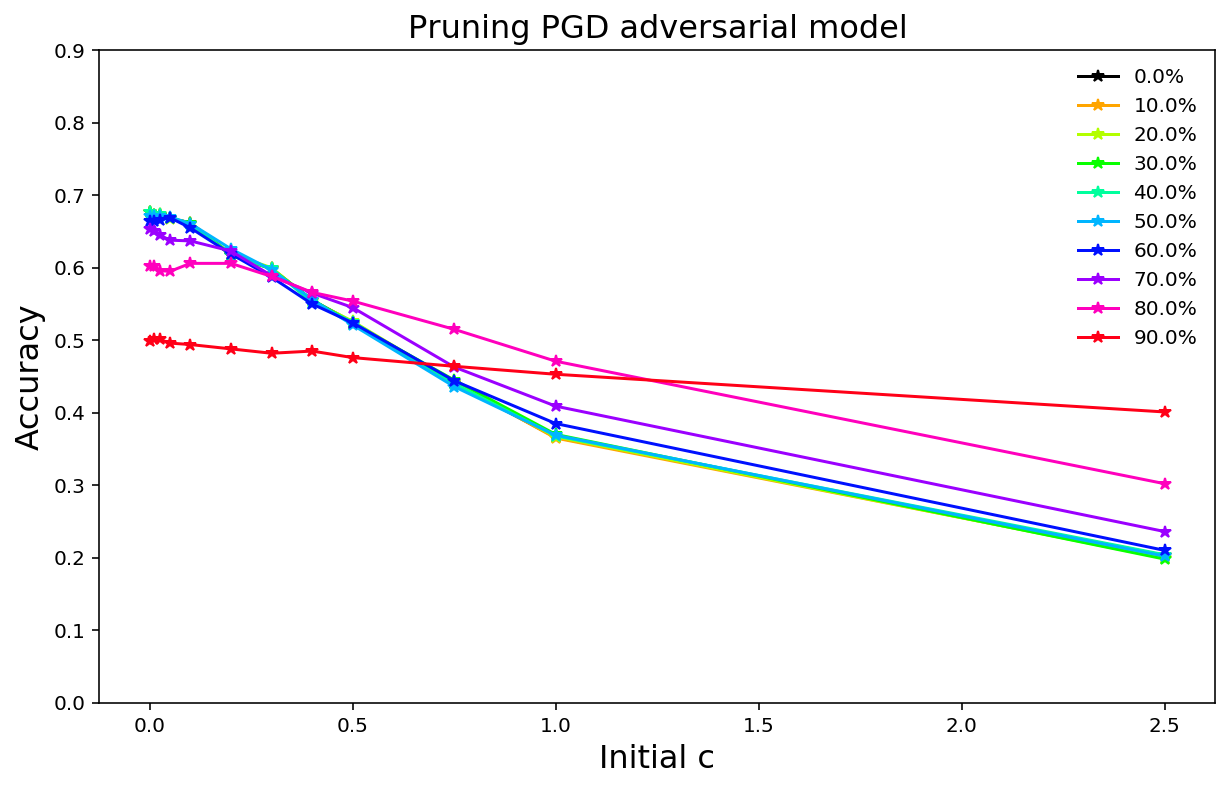

In [11]:
# plot the pruned accuracies vs constant c
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]

plt.figure(figsize=(10,6))
# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')


plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("Pruning PGD adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

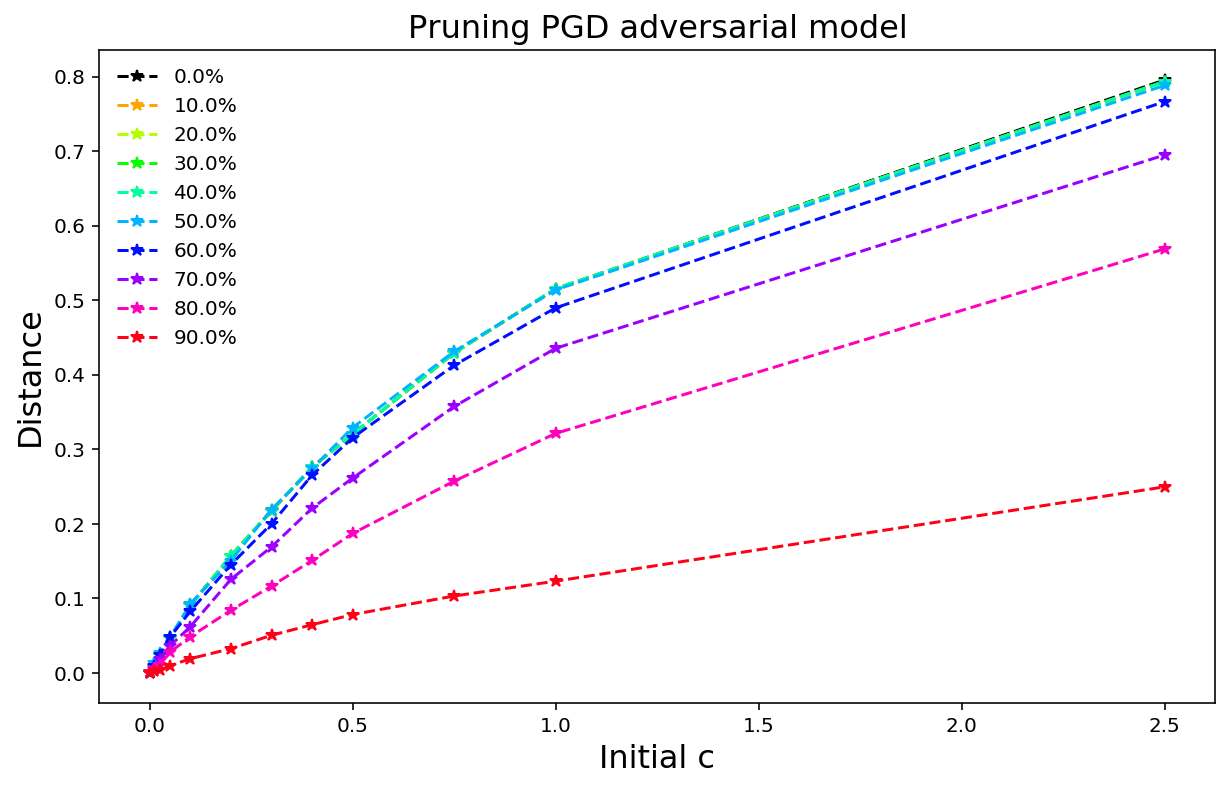

In [12]:
# plot the pruned accuracies vs constant c
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]

plt.figure(figsize=(10,6))
# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['distances'], "*--", color=colors[idx], label=str(pg*100)+'%')


# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("Pruning PGD adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Distance",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Carlini Linf

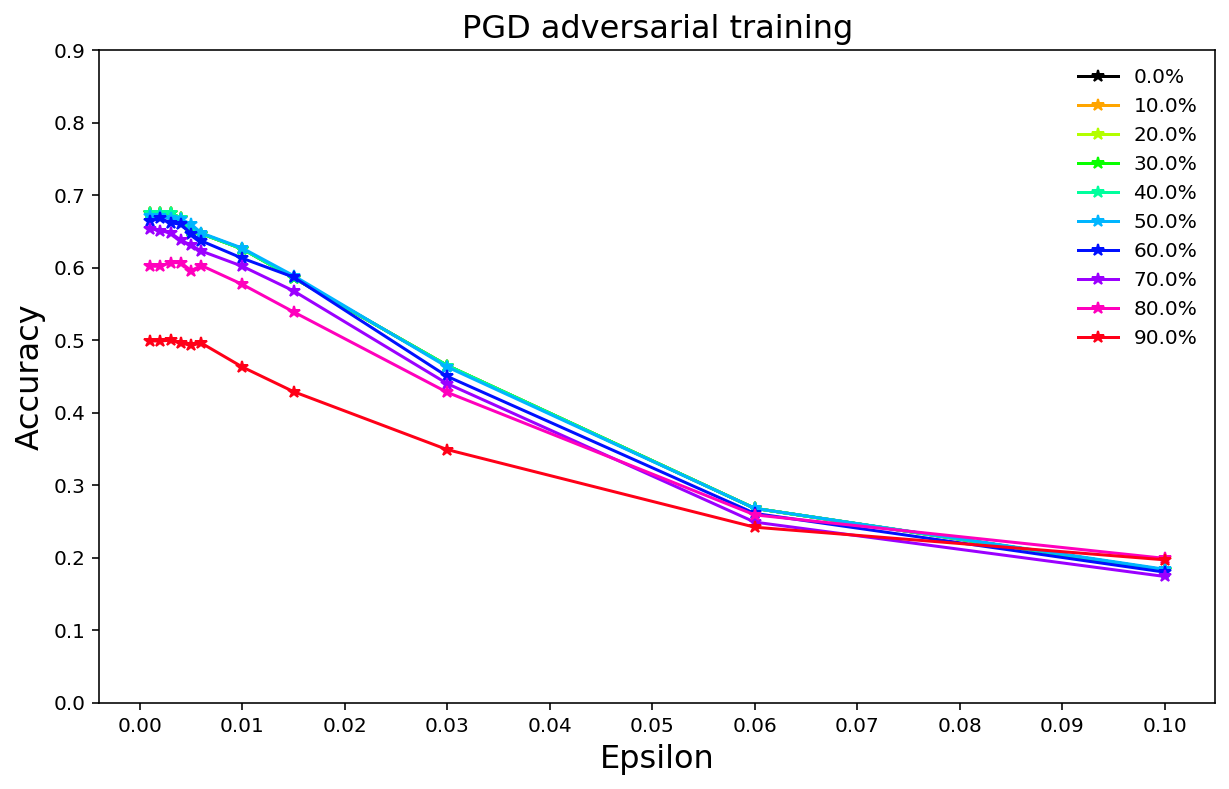

In [9]:
# plot the pruned accuracies vs epsilon
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]

plt.figure(figsize=(10,6))
# colors
n = len(carlini_inf_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_inf_prune.items()):
    plt.plot(results['epsilons'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')


plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()